# Regression with neural networks

In this example, we use a dataset documenting housing prices in the Pacific Heights section of San Francisco and train a neural network to predict what a dwelling will sell for given the number of rooms, the square footage, and other factors.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

Load the dataset and examine its content and structure.

In [2]:
df = pd.read_csv('Data/pacific-heights.csv')
df.head()

,address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zipcode
0,2243 Franklin St,2.0,2,1463,2/5/2016,1950000,37.795139,-122.425309,Pacific Heights,7,Condominium,1900,94109
1,2002 Pacific Ave APT 4,3.5,3,3291,1/22/2016,4200000,37.794429,-122.428513,Pacific Heights,7,Condominium,1961,94109
2,1945 Washington St APT 411,1.0,1,653,12/16/2015,665000,37.792472,-122.425281,Pacific Heights,3,Condominium,1987,94109
3,1896 Pacific Ave APT 802,2.5,2,2272,12/17/2014,2735000,37.794706,-122.426347,Pacific Heights,6,Condominium,1924,94109
4,1840 Washington St APT 603,1.0,1,837,12/2/2015,1050000,37.793212,-122.423744,Pacific Heights,3,Condominium,2012,94109


How many rows and columns does the dataset contain?

In [3]:
df.shape

(439, 13)

Make sure there are no missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 13 columns):
address          439 non-null object
bathrooms        439 non-null float64
bedrooms         439 non-null int64
finishedsqft     439 non-null int64
lastsolddate     439 non-null object
lastsoldprice    439 non-null int64
latitude         439 non-null float64
longitude        439 non-null float64
neighborhood     439 non-null object
totalrooms       439 non-null int64
usecode          439 non-null object
yearbuilt        439 non-null int64
zipcode          439 non-null int64
dtypes: float64(3), int64(6), object(4)
memory usage: 44.7+ KB


Call corr() on the DataFrame to compute the pairwise correlation of all columns, and filter the results to show how much each column contributes to the dwelling's last-sold price.

In [5]:
corr_matrix = df.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

lastsoldprice    1.000000
finishedsqft     0.840864
bathrooms        0.768179
totalrooms       0.670726
bedrooms         0.606579
zipcode          0.296032
latitude         0.126480
yearbuilt       -0.214365
longitude       -0.309462
Name: lastsoldprice, dtype: float64

Factor out all the columns that have a correlation less than 0.2 as well as the latitude and longitude columns, which are roughly incorporated in the zip code. Also one-hot-encode the values in the "usecode" and "zipcode" columns so they can be included in the correlation (and in the model). It is easy to imagine that the dwelling's type and location could have an impact on the selling price.

In [6]:
df = df[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'usecode', 'zipcode', 'lastsoldprice']]
df = pd.get_dummies(df, columns=['usecode', 'zipcode'])
df.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,lastsoldprice,usecode_Condominium,usecode_Cooperative,usecode_Duplex,usecode_MultiFamily2To4,usecode_SingleFamily,usecode_Townhouse,zipcode_94109,zipcode_94115,zipcode_94123
0,2.0,2,1463,7,1950000,1,0,0,0,0,0,1,0,0
1,3.5,3,3291,7,4200000,1,0,0,0,0,0,1,0,0
2,1.0,1,653,3,665000,1,0,0,0,0,0,1,0,0
3,2.5,2,2272,6,2735000,1,0,0,0,0,0,1,0,0
4,1.0,1,837,3,1050000,1,0,0,0,0,0,1,0,0


Now run the correlation again.

In [7]:
corr_matrix = df.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

lastsoldprice              1.000000
finishedsqft               0.840864
bathrooms                  0.768179
totalrooms                 0.670726
usecode_SingleFamily       0.638482
bedrooms                   0.606579
zipcode_94123              0.228418
zipcode_94115              0.071123
usecode_Duplex             0.006292
usecode_MultiFamily2To4   -0.019009
usecode_Townhouse         -0.025467
usecode_Cooperative       -0.025556
zipcode_94109             -0.243927
usecode_Condominium       -0.598575
Name: lastsoldprice, dtype: float64

Remove the use-code columns that have little bearing on the output.

In [8]:
df = df.drop(['usecode_Duplex', 'usecode_MultiFamily2To4', 'usecode_Townhouse', 'usecode_Cooperative'], axis=1)
df.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,lastsoldprice,usecode_Condominium,usecode_SingleFamily,zipcode_94109,zipcode_94115,zipcode_94123
0,2.0,2,1463,7,1950000,1,0,1,0,0
1,3.5,3,3291,7,4200000,1,0,1,0,0
2,1.0,1,653,3,665000,1,0,1,0,0
3,2.5,2,2272,6,2735000,1,0,1,0,0
4,1.0,1,837,3,1050000,1,0,1,0,0


Use Seaborn's handy [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function to visualize the relationships between non-categorical variables.

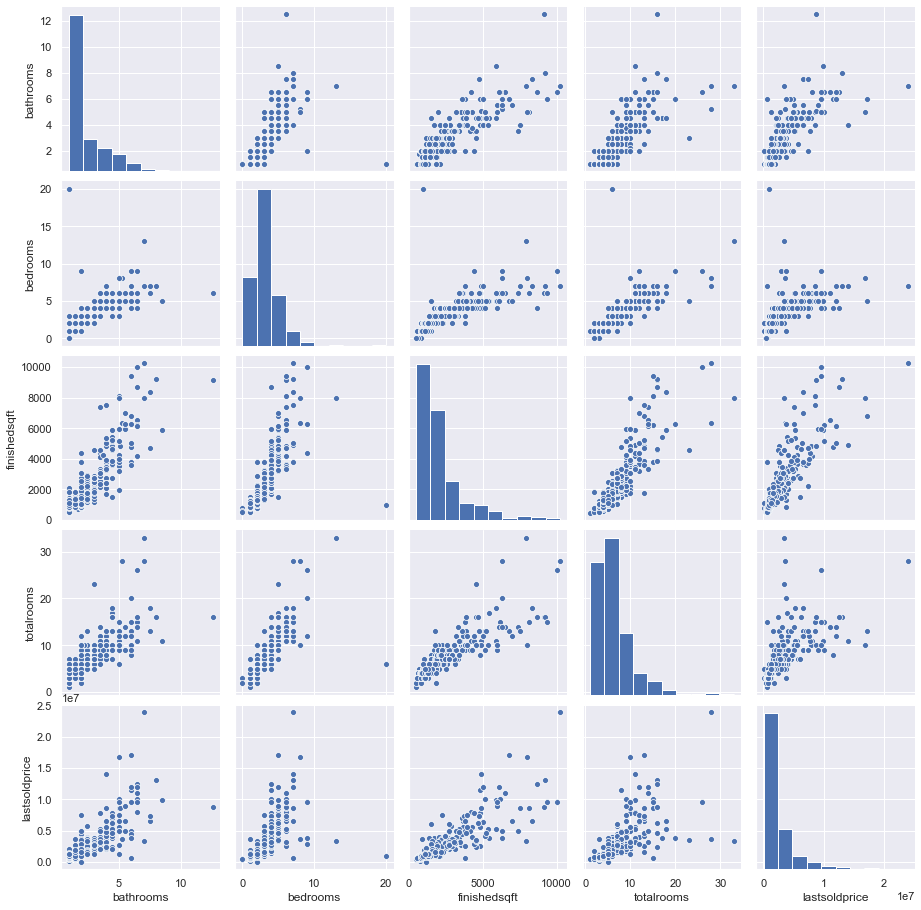

In [9]:
sns.pairplot(df[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'lastsoldprice']])

Split the dataset for training and testing.

In [10]:
from sklearn.model_selection import train_test_split

x = df.drop('lastsoldprice', axis=1)
y = df['lastsoldprice']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Now build a neural network containing two hidden layers and train it with the training data.

In [11]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_dim=9, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1)) 
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


In [12]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20)

Train on 351 samples, validate on 88 samples
Epoch 1/100
351/351 [==============================] - 0s 359us/step - loss: 2499061.2479 - mae: 2499061.2500 - val_loss: 2590532.7557 - val_mae: 2590532.7500
Epoch 2/100
351/351 [==============================] - 0s 71us/step - loss: 2496642.8155 - mae: 2496642.7500 - val_loss: 2587526.0909 - val_mae: 2587526.2500
Epoch 3/100
351/351 [==============================] - 0s 68us/step - loss: 2492711.1966 - mae: 2492711.2500 - val_loss: 2582331.0284 - val_mae: 2582331.2500
Epoch 4/100
351/351 [==============================] - 0s 74us/step - loss: 2486149.9395 - mae: 2486149.7500 - val_loss: 2573761.1534 - val_mae: 2573761.2500
Epoch 5/100
351/351 [==============================] - 0s 71us/step - loss: 2475733.7037 - mae: 2475733.7500 - val_loss: 2560551.1705 - val_mae: 2560551.0000
Epoch 6/100
351/351 [==============================] - 0s 68us/step - loss: 2460198.1588 - mae: 2460198.5000 - val_loss: 2541151.3807 - val_mae: 2541151.5000
Epoch 

351/351 [==============================] - 0s 68us/step - loss: 743450.1517 - mae: 743450.1875 - val_loss: 804879.1477 - val_mae: 804879.1875
Epoch 54/100
351/351 [==============================] - 0s 66us/step - loss: 744347.3360 - mae: 744347.3750 - val_loss: 801270.0057 - val_mae: 801270.0000
Epoch 55/100
351/351 [==============================] - 0s 74us/step - loss: 744069.6553 - mae: 744069.6250 - val_loss: 804925.1960 - val_mae: 804925.1875
Epoch 56/100
351/351 [==============================] - 0s 68us/step - loss: 743177.7914 - mae: 743177.8125 - val_loss: 804364.0426 - val_mae: 804364.0625
Epoch 57/100
351/351 [==============================] - 0s 68us/step - loss: 743899.2880 - mae: 743899.3125 - val_loss: 803077.2912 - val_mae: 803077.2500
Epoch 58/100
351/351 [==============================] - 0s 74us/step - loss: 743179.7415 - mae: 743179.7500 - val_loss: 802484.7159 - val_mae: 802484.7500
Epoch 59/100
351/351 [==============================] - 0s 66us/step - loss: 744037

Plot the training accuracy and validation accuracy over time.

[]

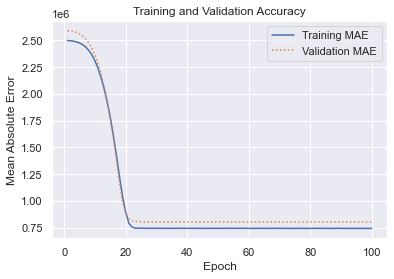

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

Get the coefficient of determination (R2) to determine how accurate the model is.

In [14]:
from sklearn.metrics import r2_score

r2_score(y_test, model.predict(x_test))

0.6284856657440459

Show other accuracy metrics.

In [15]:
scores = model.evaluate(x_test, y_test, verbose=0)

for i in range(0, len(scores)):
    print(model.metrics_names[i] + ': ' + str(scores[i]))

loss: 801730.5852272727
mae: 801730.5625


What would a single-family home with 2 bathrooms, 2 bedrooms, 7 total rooms, and 2,000 square feet of space sell for in zip code 94115?

In [16]:
import numpy as np

bathrooms = 1
bedrooms = 1
finished_sqft = 1040
total_rooms = 4
usecode_Condominium = 1
usecode_SingleFamily = 0
zipcode_94109 = 0
zipcode_94115 = 1
zipcode_94123 = 0

model.predict(np.array([[bathrooms, bedrooms, finished_sqft, total_rooms, usecode_Condominium, usecode_SingleFamily, zipcode_94109, zipcode_94115, zipcode_94123]]))

array([[1083382.]], dtype=float32)